<a href="https://colab.research.google.com/github/sujit49/Brain-Tumor-ml-model/blob/main/Brain%20Tumor%20model%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel scikit-image matplotlib tensorflow --quiet


In [2]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import resize
import matplotlib.pyplot as plt

# Enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

DATASET_DIR = "/content/brats_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"


In [5]:
!pip install kaggle --quiet

# Upload kaggle.json manually or use this code if you have it locally
from google.colab import files
files.upload()  # select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sujitarunraut","key":"a5caef50cf960d841d4f0d8ca835fb47"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation
!unzip -q brats20-dataset-training-validation.zip -d brats_dataset


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.11G/4.16G [00:57<00:00, 325MB/s]
100% 4.16G/4.16G [00:58<00:00, 77.0MB/s]


In [8]:
patients = sorted([os.path.join(DATASET_DIR, p) for p in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR,p))])
print(f"Found {len(patients)} patients")


Found 369 patients


In [9]:
train_dirs, val_dirs = train_test_split(patients, test_size=0.2, random_state=42)


In [10]:
def __getitem__(self, idx):
    batch_dirs = self.patient_dirs[idx*self.batch_size:(idx+1)*self.batch_size]
    X_batch, Y_batch = [], []

    for p in batch_dirs:
        patient_name = os.path.basename(p)
        files = [f"{patient_name}_flair.nii",
                 f"{patient_name}_t1.nii",
                 f"{patient_name}_t1ce.nii",
                 f"{patient_name}_t2.nii",
                 f"{patient_name}_seg.nii"]

        # Skip if any file is missing
        if not all(os.path.exists(os.path.join(p,f)) for f in files):
            print(f"Skipping {patient_name}, missing files")
            continue

        # Load images
        flair = nib.load(os.path.join(p, f"{patient_name}_flair.nii")).get_fdata()
        t1 = nib.load(os.path.join(p, f"{patient_name}_t1.nii")).get_fdata()
        t1ce = nib.load(os.path.join(p, f"{patient_name}_t1ce.nii")).get_fdata()
        t2 = nib.load(os.path.join(p, f"{patient_name}_t2.nii")).get_fdata()
        seg = nib.load(os.path.join(p, f"{patient_name}_seg.nii")).get_fdata()

        # Resize to input shape
        flair = resize(flair, self.input_shape[:3], preserve_range=True)
        t1 = resize(t1, self.input_shape[:3], preserve_range=True)
        t1ce = resize(t1ce, self.input_shape[:3], preserve_range=True)
        t2 = resize(t2, self.input_shape[:3], preserve_range=True)
        seg = resize(seg, self.input_shape[:3], preserve_range=True, order=0)

        X = np.stack([flair,t1,t1ce,t2], axis=-1).astype(np.float32)
        X = (X - np.mean(X)) / (np.std(X)+1e-5)
        y = (seg>0).astype(np.float32)
        y = np.expand_dims(y, axis=-1)

        # Patch extraction
        x_max, y_max, z_max = self.input_shape[0]-self.patch_size[0], self.input_shape[1]-self.patch_size[1], self.input_shape[2]-self.patch_size[2]
        x0, y0, z0 = np.random.randint(0, x_max+1), np.random.randint(0, y_max+1), np.random.randint(0, z_max+1)
        X = X[x0:x0+self.patch_size[0], y0:y0+self.patch_size[1], z0:z0+self.patch_size[2], :]
        y = y[x0:x0+self.patch_size[0], y0:y0+self.patch_size[1], z0:z0+self.patch_size[2], :]

        # Augmentation
        if self.augment:
            if np.random.rand() < 0.5:
                X = np.flip(X, axis=0); y = np.flip(y, axis=0)
            if np.random.rand() < 0.5:
                X = np.rot90(X, k=1, axes=(0,1)); y = np.rot90(y, k=1, axes=(0,1))
            if np.random.rand() < 0.5:
                X = X * np.random.uniform(0.9,1.1)

        X_batch.append(X)
        Y_batch.append(y)

    # Make sure batch is not empty
    if len(X_batch) == 0:
        # Pick a random patient and process it
        p = np.random.choice(self.patient_dirs)
        return self.__getitem__(self.patient_dirs.index(p))

    return np.array(X_batch), np.array(Y_batch)



In [11]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [12]:
def conv3d_block(x, filters):
    x = layers.Conv3D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv3D(filters, 3, padding="same", activation="relu")(x)
    return x

def unet_3d(input_shape=(64,64,32,4)):
    inputs = layers.Input(input_shape)

    c1 = conv3d_block(inputs, 16); p1 = layers.MaxPooling3D()(c1)
    c2 = conv3d_block(p1, 32); p2 = layers.MaxPooling3D()(c2)
    c3 = conv3d_block(p2, 64); p3 = layers.MaxPooling3D()(c3)

    bn = conv3d_block(p3, 128)

    u3 = layers.UpSampling3D()(bn); u3 = layers.Concatenate()([u3, c3])
    c6 = conv3d_block(u3, 64)

    u2 = layers.UpSampling3D()(c6); u2 = layers.Concatenate()([u2, c2])
    c7 = conv3d_block(u2, 32)

    u1 = layers.UpSampling3D()(c7); u1 = layers.Concatenate()([u1, c1])
    c8 = conv3d_block(u1, 16)

    outputs = layers.Conv3D(1,1,activation="sigmoid", dtype='float32')(c8)  # float32 for dice

    return models.Model(inputs, outputs)

model = unet_3d()
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 32, 4)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64,    │      1,744 │ input_layer[0][0] │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 64,    │      6,928 │ conv3d[0][0]      │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 16, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │     13,856 │ max_pooling3d[0]… │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │     27,680 │ conv3d_2[0][0]    │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 16, 8, │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 16, 8, │     55,360 │ max_pooling3d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16, 8, │    110,656 │ conv3d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 8, 8, 4,   │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 8, 4,   │    221,312 │ max_pooling3d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 8, 8, 4,   │    442,496 │ conv3d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 16, 16, 8, │          0 │ conv3d_7[0][0]    │
│ (UpSampling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16, 8, │          0 │ up_sampling3d[0]… │
│ (Concatenate)       │ 192)              │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 16, 16, 8, │    331,840 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 16, 16, 8, │    110,656 │ conv3d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_1     │ (None, 32, 32,    │          0 │ conv3d_9[0][0]  

 Total params: 1,460,881 (5.57 MB)

 Trainable params: 1,460,881 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from tensorflow.keras.utils import Sequence

class Brats3DGenerator(Sequence):
    def __init__(self, patient_dirs, batch_size=1, patch_size=(64,64,32), input_shape=(128,128,128,4), augment=True):
        self.patient_dirs = patient_dirs
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.input_shape = input_shape
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.patient_dirs)/self.batch_size))

    def __getitem__(self, idx):
        batch_dirs = self.patient_dirs[idx*self.batch_size:(idx+1)*self.batch_size]
        X_batch, Y_batch = [], []

        for p in batch_dirs:
            patient_name = os.path.basename(p)
            files = [f"{patient_name}_flair.nii",
                     f"{patient_name}_t1.nii",
                     f"{patient_name}_t1ce.nii",
                     f"{patient_name}_t2.nii",
                     f"{patient_name}_seg.nii"]

            if not all(os.path.exists(os.path.join(p,f)) for f in files):
                print(f"Skipping {patient_name}, missing files")
                continue

            flair = nib.load(os.path.join(p, f"{patient_name}_flair.nii")).get_fdata()
            t1 = nib.load(os.path.join(p, f"{patient_name}_t1.nii")).get_fdata()
            t1ce = nib.load(os.path.join(p, f"{patient_name}_t1ce.nii")).get_fdata()
            t2 = nib.load(os.path.join(p, f"{patient_name}_t2.nii")).get_fdata()
            seg = nib.load(os.path.join(p, f"{patient_name}_seg.nii")).get_fdata()

            flair = resize(flair, self.input_shape[:3], preserve_range=True)
            t1 = resize(t1, self.input_shape[:3], preserve_range=True)
            t1ce = resize(t1ce, self.input_shape[:3], preserve_range=True)
            t2 = resize(t2, self.input_shape[:3], preserve_range=True)
            seg = resize(seg, self.input_shape[:3], preserve_range=True, order=0)

            X = np.stack([flair, t1, t1ce, t2], axis=-1).astype(np.float32)
            X = (X - np.mean(X)) / (np.std(X)+1e-5)
            y = (seg>0).astype(np.float32)
            y = np.expand_dims(y, axis=-1)

            x_max, y_max, z_max = self.input_shape[0]-self.patch_size[0], self.input_shape[1]-self.patch_size[1], self.input_shape[2]-self.patch_size[2]
            x0, y0, z0 = np.random.randint(0, x_max+1), np.random.randint(0, y_max+1), np.random.randint(0, z_max+1)
            X = X[x0:x0+self.patch_size[0], y0:y0+self.patch_size[1], z0:z0+self.patch_size[2], :]
            y = y[x0:x0+self.patch_size[0], y0:y0+self.patch_size[1], z0:z0+self.patch_size[2], :]

            if self.augment:
                if np.random.rand() < 0.5:
                    X = np.flip(X, axis=0); y = np.flip(y, axis=0)
                if np.random.rand() < 0.5:
                    X = np.rot90(X, k=1, axes=(0,1)); y = np.rot90(y, k=1, axes=(0,1))
                if np.random.rand() < 0.5:
                    X = X * np.random.uniform(0.9,1.1)

            X_batch.append(X)
            Y_batch.append(y)

        if len(X_batch) == 0:
            p = np.random.choice(self.patient_dirs)
            return self.__getitem__(self.patient_dirs.index(p))

        return np.array(X_batch), np.array(Y_batch)


In [14]:
train_gen = Brats3DGenerator(train_dirs, batch_size=1, patch_size=(64,64,32))
val_gen = Brats3DGenerator(val_dirs, batch_size=1, patch_size=(64,64,32), augment=False)


In [15]:
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_dice_coef", save_best_only=True, mode="max")


In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
239/295 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - dice_coef: 0.1253 - loss: 0.8747Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.1349 - loss: 0.8651

295/295 ━━━━━━━━━━━━━━━━━━━━ 789s 3s/step - dice_coef: 0.1351 - loss: 0.8649 - val_dice_coef: 0.1216 - val_loss: 0.8784
Epoch 2/10
150/295 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - dice_coef: 0.2700 - loss: 0.7300Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.2668 - loss: 0.7332

295/295 ━━━━━━━━━━━━━━━━━━━━ 763s 3s/step - dice_coef: 0.2668 - loss: 0.7332 - val_dice_coef: 0.2973 - val_loss: 0.7027
Epoch 3/10
 18/295 ━━━━━━━━━━━━━━━━━━━━ 9:28 2s/step - dice_coef: 0.2656 - loss: 0.7344Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 758s 3s/step - dice_coef: 0.3048 - loss: 0.6952 - val_dice_coef: 0.2027 - val_loss: 0.7973
Epoch 4/10
211/295 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - dice_coef: 0.2068 - loss: 0.7932Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 812s 3s/step - dice_coef: 0.2073 - loss: 0.7927 - val_dice_coef: 0.1757 - val_loss: 0.8243
Epoch 5/10
111/295 ━━━━━━━━━━━━━━━━━━━━ 6:23 2s/step - dice_coef: 0.2362 - loss: 0.7638Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 768s 3s/step - dice_coef: 0.2437 - loss: 0.7563 - val_dice_coef: 0.2297 - val_loss: 0.7703
Epoch 6/10
 35/295 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - dice_coef: 0.3173 - loss: 0.6827Skipping BraTS20_Training_355, missin

295/295 ━━━━━━━━━━━━━━━━━━━━ 767s 3s/step - dice_coef: 0.2859 - loss: 0.7141 - val_dice_coef: 0.3919 - val_loss: 0.6081
Epoch 9/10
198/295 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - dice_coef: 0.2836 - loss: 0.7164Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 765s 3s/step - dice_coef: 0.2726 - loss: 0.7274 - val_dice_coef: 0.3378 - val_loss: 0.6622
Epoch 10/10
188/295 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - dice_coef: 0.2404 - loss: 0.7596Skipping BraTS20_Training_355, missing files
295/295 ━━━━━━━━━━━━━━━━━━━━ 769s 3s/step - dice_coef: 0.2558 - loss: 0.7442 - val_dice_coef: 0.2297 - val_loss: 0.7703


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


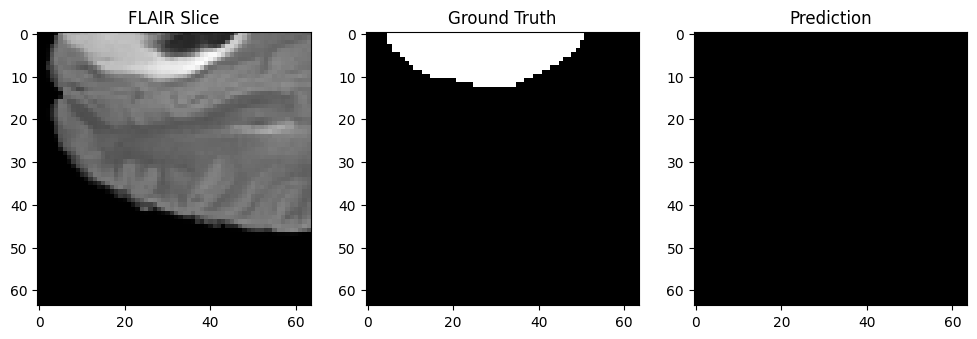

In [17]:
X_val_sample, Y_val_sample = val_gen[0]
pred_vol = model.predict(X_val_sample)[0,:,:,:,0]
pred_bin = (pred_vol>0.5).astype(np.uint8)

z = pred_vol.shape[2]//2
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("FLAIR Slice"); plt.imshow(X_val_sample[0][:,:,z,0], cmap="gray")
plt.subplot(1,3,2)
plt.title("Ground Truth"); plt.imshow(Y_val_sample[0][:,:,z,0], cmap="gray")
plt.subplot(1,3,3)
plt.title("Prediction"); plt.imshow(pred_bin[:,:,z], cmap="gray")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


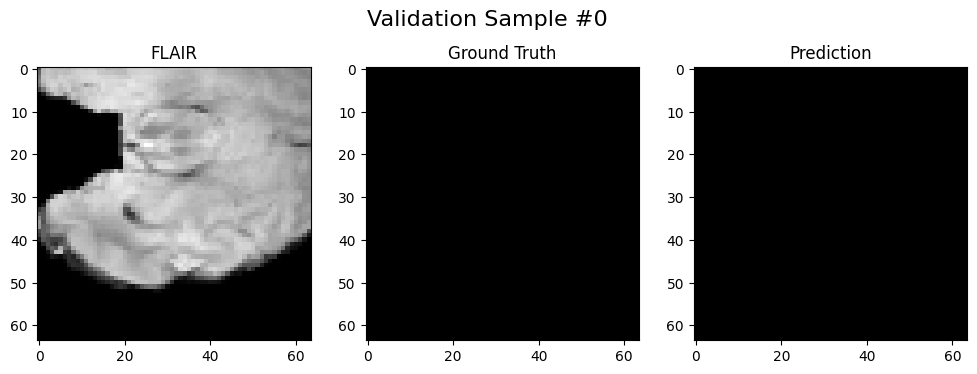

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


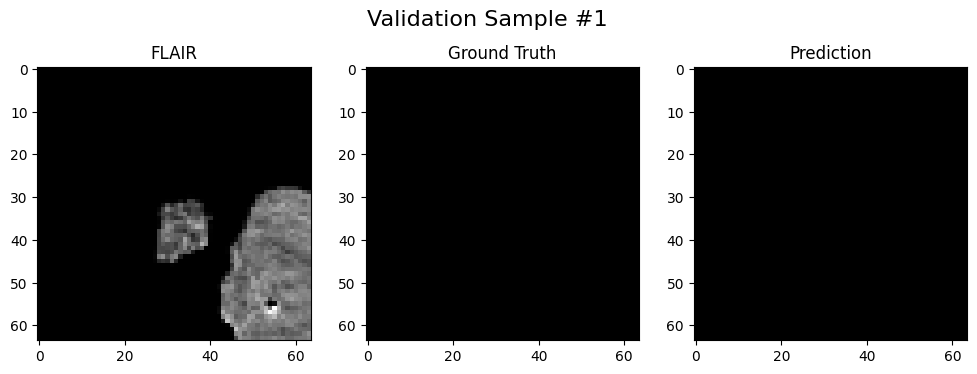

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


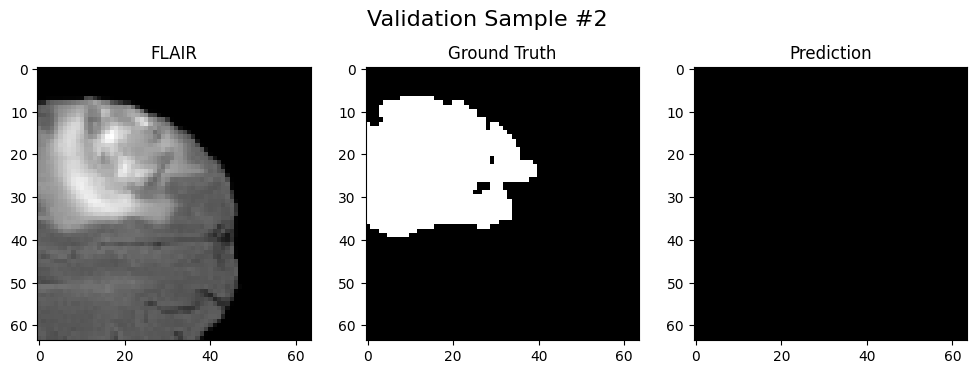

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


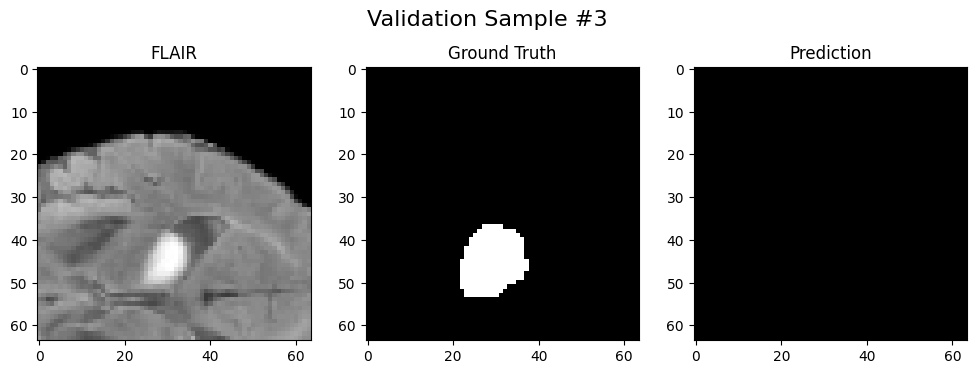

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


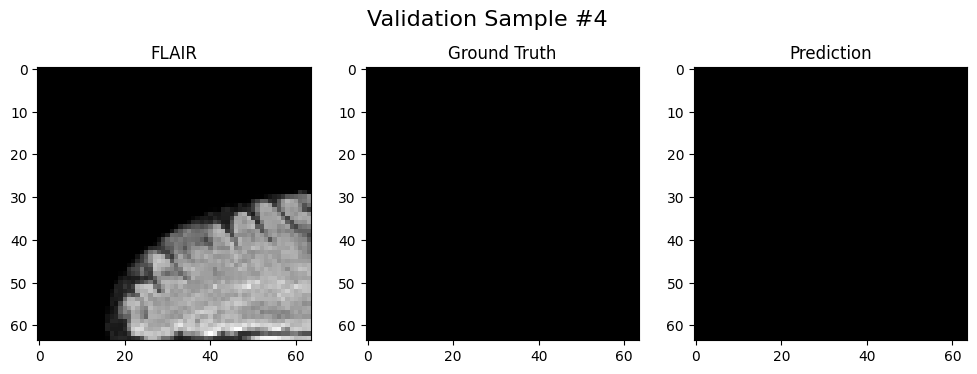

In [18]:
N = 5   # how many samples you want to visualize

for i in range(N):
    X_batch, Y_batch = val_gen[i]     # load patch i
    pred = model.predict(X_batch)[0,:,:,:,0]
    pred_bin = (pred>0.5).astype(np.uint8)

    z = pred.shape[2]//2

    plt.figure(figsize=(12,4))
    plt.suptitle(f"Validation Sample #{i}", fontsize=16)

    plt.subplot(1,3,1)
    plt.title("FLAIR")
    plt.imshow(X_batch[0][:,:,z,0], cmap="gray")

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(Y_batch[0][:,:,z,0], cmap="gray")

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred_bin[:,:,z], cmap="gray")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


IndexError: index 40 is out of bounds for axis 2 with size 32

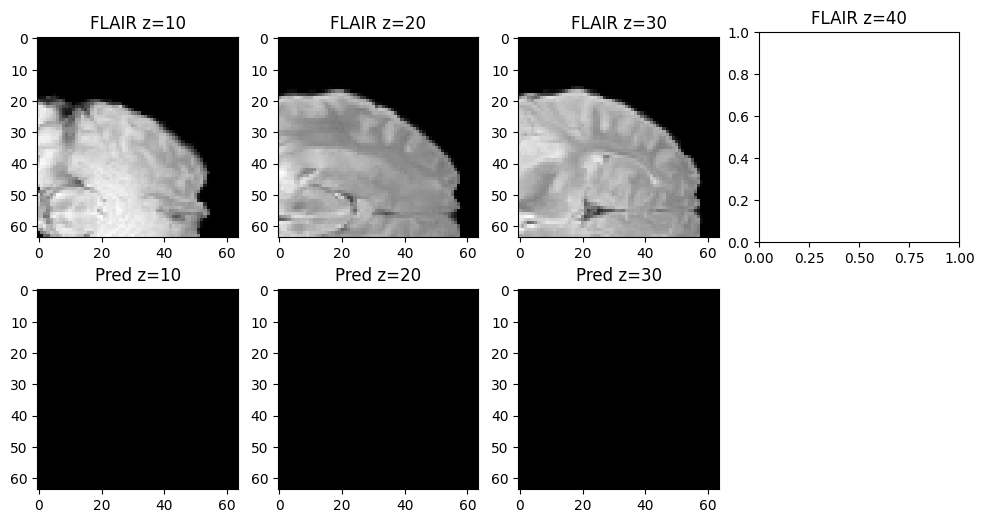

In [19]:
X_batch, Y_batch = val_gen[0]
pred = model.predict(X_batch)[0,:,:,:,0]
pred_bin = (pred>0.5).astype(np.uint8)

slices = [10, 20, 30, 40, 50]

plt.figure(figsize=(15,6))

for i, z in enumerate(slices):
    plt.subplot(2, len(slices), i+1)
    plt.title(f"FLAIR z={z}")
    plt.imshow(X_batch[0][:,:,z,0], cmap="gray")

    plt.subplot(2, len(slices), i+1+len(slices))
    plt.title(f"Pred z={z}")
    plt.imshow(pred_bin[:,:,z], cmap="gray")

plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


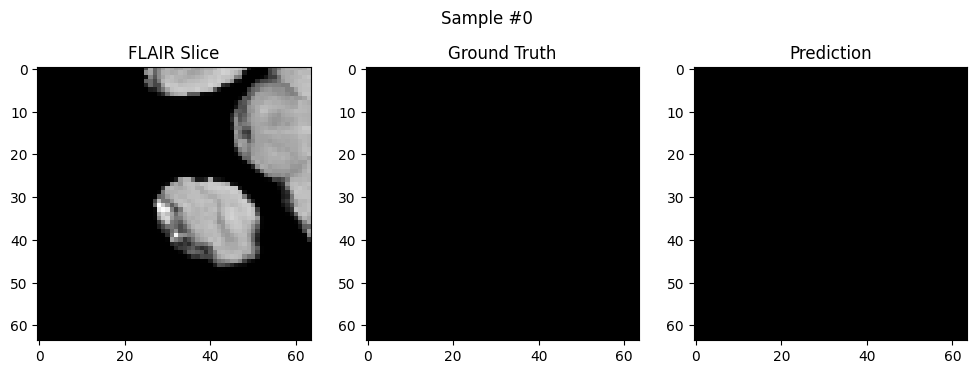

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


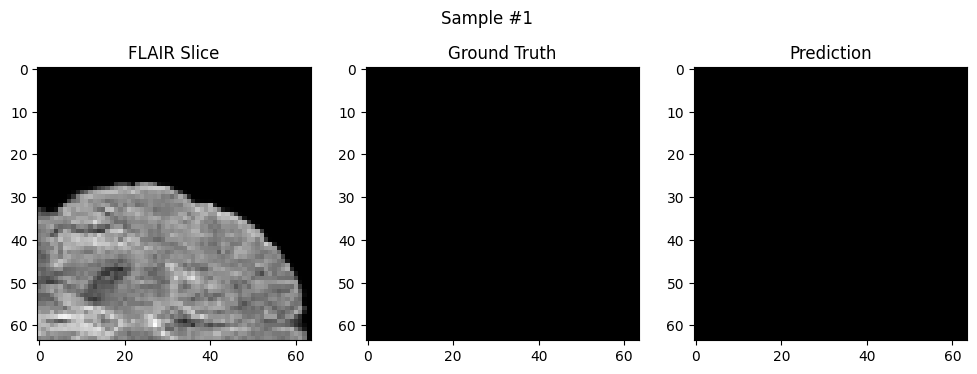

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


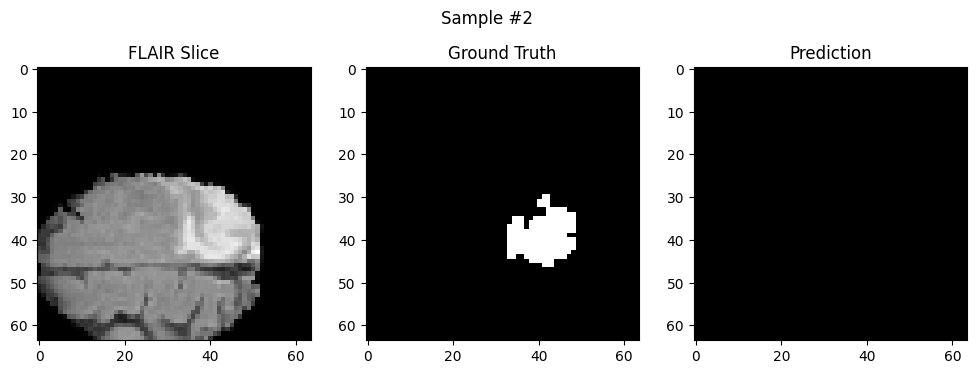

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


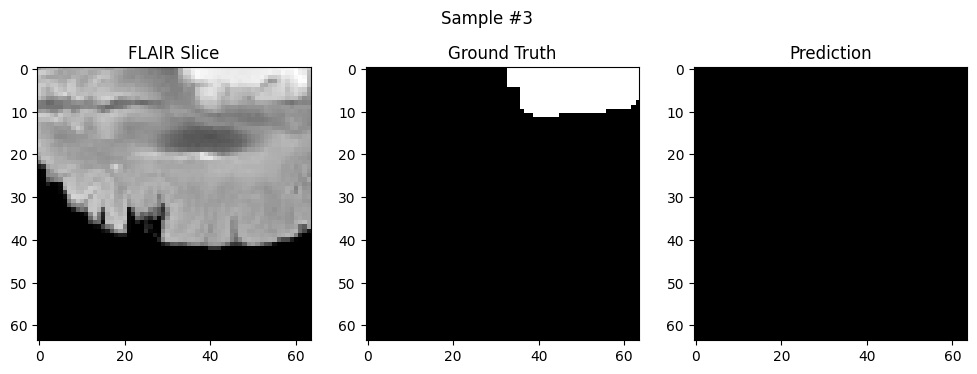

In [22]:
def show_multiple_patients(val_gen, model, num_samples=4):
    for i in range(num_samples):
        X_val, Y_val = val_gen[i]
        pred = model.predict(X_val)[0,:,:,:,0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        mid = pred.shape[2] // 2

        plt.figure(figsize=(12,4))
        plt.suptitle(f"Sample #{i}")

        plt.subplot(1,3,1)
        plt.title("FLAIR Slice")
        plt.imshow(X_val[0][:,:,mid,0], cmap="gray")

        plt.subplot(1,3,2)
        plt.title("Ground Truth")
        plt.imshow(Y_val[0][:,:,mid,0], cmap="gray")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(pred_bin[:,:,mid], cmap="gray")

        plt.show()

# Run this:
show_multiple_patients(val_gen, model, num_samples=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


IndexError: index 40 is out of bounds for axis 2 with size 32

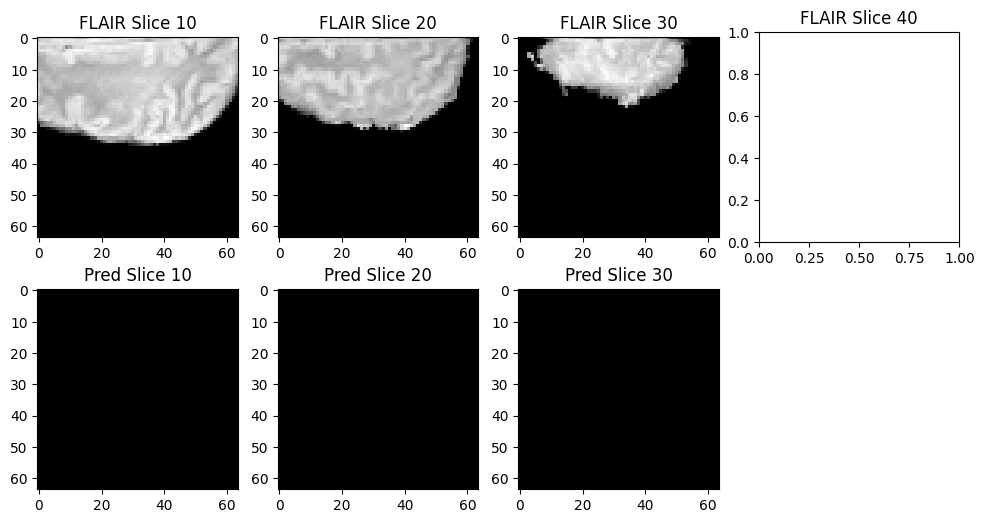

In [23]:
def show_multiple_slices(val_gen, model, sample_id=0):
    X_val, Y_val = val_gen[sample_id]
    pred = model.predict(X_val)[0,:,:,:,0]
    pred_bin = (pred > 0.5).astype(np.uint8)

    slices = [10, 20, 30, 40, 50]

    plt.figure(figsize=(15,6))
    for idx, s in enumerate(slices):
        plt.subplot(2, len(slices), idx + 1)
        plt.title(f"FLAIR Slice {s}")
        plt.imshow(X_val[0][:,:,s,0], cmap='gray')

        plt.subplot(2, len(slices), idx + 1 + len(slices))
        plt.title(f"Pred Slice {s}")
        plt.imshow(pred_bin[:,:,s], cmap='gray')

    plt.tight_layout()
    plt.show()

# Run:
show_multiple_slices(val_gen, model, sample_id=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


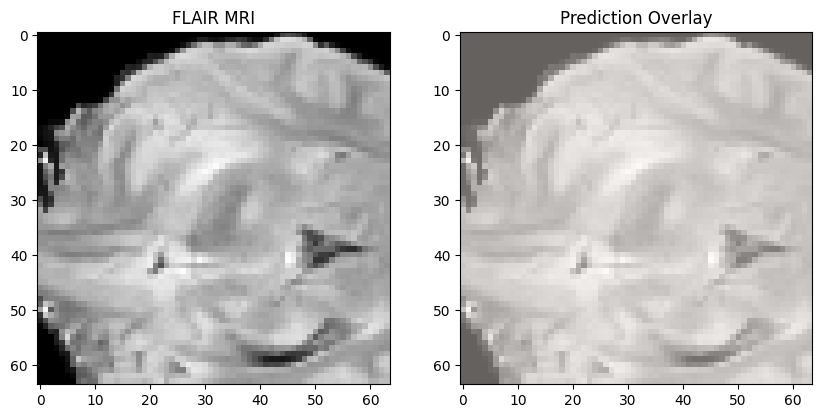

In [25]:
def overlay_prediction(val_gen, model, sample_id=0):
    X_val, Y_val = val_gen[sample_id]
    pred = model.predict(X_val)[0,:,:,:,0]
    pred_bin = (pred > 0.5).astype(np.uint8)

    z = pred.shape[2]//2

    flair_slice = X_val[0][:,:,z,0]
    mask = pred_bin[:,:,z]

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title("FLAIR MRI")
    plt.imshow(flair_slice, cmap="gray")

    plt.subplot(1,2,2)
    plt.title("Prediction Overlay")
    plt.imshow(flair_slice, cmap="gray")
    plt.imshow(mask, cmap='Reds', alpha=0.4)  # transparent overlay

    plt.show()

# RUN:
overlay_prediction(val_gen, model, sample_id=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


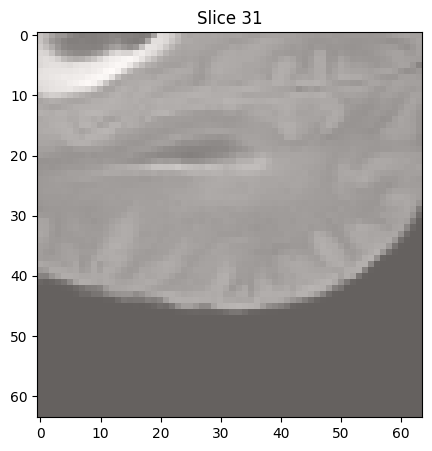

In [26]:
def animate_volume(val_gen, model, sample_id=0):
    X_val, Y_val = val_gen[sample_id]
    pred = model.predict(X_val)[0,:,:,:,0]
    pred_bin = (pred > 0.5).astype(np.uint8)

    fig = plt.figure(figsize=(5,5))
    z_dim = pred.shape[2]

    def animate(i):
        plt.clf()
        plt.title(f"Slice {i}")
        plt.imshow(X_val[0][:,:,i,0], cmap="gray")
        plt.imshow(pred_bin[:,:,i], cmap='Reds', alpha=0.4)

    anim = animation.FuncAnimation(fig, animate, frames=z_dim, interval=120)
    return HTML(anim.to_jshtml())

# RUN:
animate_volume(val_gen, model, sample_id=0)
